In [1]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import mannwhitneyu
print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')

numpy version: 2.2.2
pandas version: 2.2.3


In [2]:
DATA_LOCATION = 'Mimic3_Data'
OUTPUT = 'ImagesOutput'

In [3]:
def normalize_race(race):
    if 'HISPANIC' in race:
        return 'Hispanic'
    if 'SOUTH AMERICAN' in race:
        return 'Hispanic'
    if 'AMERICAN INDIAN' in race:
        return 'Native American'
    if 'ASIAN' in race:
        return 'Asian'
    if 'BLACK' in race:
        return 'Black'
    if 'UNKNOWN/NOT SPECIFIED' in race:
        return 'Not Specified'
    if 'WHITE' in race:
        return 'White'
    #print race
    return 'Other'

def normalize_insurance(ins):
    if ins in ['Government', 'Medicaid', 'Medicare']:
        return 'Public'
    elif ins == 'Private':
        return 'Private'
    else:
        return 'Self-Pay'

def normalize_discharge(disch):
    if disch.startswith('HOSPICE'):
        return 'Hospice'
    if disch == 'DEAD/EXPIRED':
        return 'Deceased'
    if disch.startswith('SNF'):
        return 'Skilled Nursing Facility'
    return 'other'

def normalize_codestatus(code):
    if code is not None:
        if ('DNR' in code) or ('DNI' in code) or ('Comfort' in code) or ('Do Not' in code):
            label = 'DNR/CMO'
        elif (code == 'Full Code') or (code == 'Full code'):
            label = 'Full Code'
        else:
            label = code
    else:
        label = 'Not specified'
    return label

    
def normalize_age(age):
    return min(age, 90)

In [4]:
demographics = pd.read_parquet(f'{DATA_LOCATION}/demographics.parquet')
demographics = demographics.drop_duplicates(['HADM_ID', 'ETHNICITY'])

In [5]:
discharge = pd.read_parquet(f'{DATA_LOCATION}/discharge.parquet')
discharge['DISCHARGE_LOCATION'] = discharge['DISCHARGE_LOCATION'].apply(normalize_discharge)

In [6]:
eol_locations = {'Hospice', 'Deceased', 'Skilled Nursing Facility'}
disch = discharge[discharge['DISCHARGE_LOCATION'].isin(eol_locations)]
ids = set(disch['HADM_ID'].unique())
eol_cohort_initial = discharge[discharge['HADM_ID'].isin(ids)]
eol_cohort_initial = eol_cohort_initial[eol_cohort_initial['DISCHTIME'] - eol_cohort_initial['ADMITTIME'] >= pd.Timedelta(days=1)]
eol_cohort = eol_cohort_initial.merge(demographics, on=['HADM_ID', 'ETHNICITY'])
eol_cohort = eol_cohort.rename(columns={'ETHNICITY': 'RACE'})
eol_cohort['RACE'] = eol_cohort['RACE'].apply(normalize_race)
eol_cohort['INSURANCE'] = eol_cohort['INSURANCE'].apply(normalize_insurance)
eol_cohort['DISCHARGE_LOCATION'] = eol_cohort['DISCHARGE_LOCATION'].apply(normalize_discharge)
eol_cohort['AGE'] = eol_cohort['AGE'].apply(normalize_age)
eol_cohort['LOS'] = (eol_cohort['DISCHTIME'] - eol_cohort['ADMITTIME']).dt.seconds / 3600
assert len(eol_cohort) == len(eol_cohort['HADM_ID'].unique())
print('eol subjects:', len(eol_cohort))

eol subjects: 9477


In [7]:
race_eol = {}
race_eol['White'] = eol_cohort[eol_cohort['RACE'] == 'White']
race_eol['Black'] = eol_cohort[eol_cohort['RACE'] == 'Black']

In [8]:
def find(groups, it):
    for i,group in enumerate(groups):
        if it in group:
            return i

        
def transitive_closure(items, merge):
    groups = [ [it] for it in items ]
    for a,b in merge:
        # make sure a and b are in the same group
        group_a = find(groups, a)
        group_b = find(groups, b)
        if group_a < group_b:
            group_ab = groups[group_a] + groups[group_b]
            del groups[group_b]
            del groups[group_a]
            groups.append(group_ab)
        elif group_a > group_b:
            group_ab = groups[group_a] + groups[group_b]
            del groups[group_a]
            del groups[group_b]
            groups.append(group_ab)
        else:
            # already same group
            pass
    return groups


def treatment_quantity(duration_aggregate, treatment_df):
    spans = defaultdict(list)
    for hadm_id,rows in treatment_df.groupby('HADM_ID'):
        rows =  rows.sort_values('STARTTIME')

        if duration_aggregate == 'max-min':
            span = rows.iloc[-1]['ENDTIME'] - rows.iloc[0]['STARTTIME']
            assert span > pd.Timedelta(days=0)
            spans[hadm_id].append(span)   
        elif duration_aggregate == 'sum_spans':
            merge = []
            for i in range(len(rows)-1):
                if rows.iloc[i+1]['STARTTIME'] - rows.iloc[i]['ENDTIME'] <= pd.Timedelta(hours=10):
                    merge.append( (i,i+1) )

            for group in transitive_closure(range(len(rows)), merge):
                lo = min(group)
                hi = max(group)
                span = rows.iloc[hi]['ENDTIME'] - rows.iloc[lo]['STARTTIME']
                assert span >= pd.Timedelta(days=0)
                spans[hadm_id].append(span)
        else:
            raise Exception('dunno!')

    quantity = { hadm_id:sum([ts.total_seconds()/60. for ts in timestamps]) for hadm_id,timestamps in spans.items() }
    #quantity = { hadm_id:timestamps[0].total_seconds()/60. for hadm_id,timestamps in spans.items() }
    #quantity = { hadm_id:timestamps[-1].total_seconds()/60. for hadm_id,timestamps in spans.items() }
    
    return quantity


In [9]:
vent_df = pd.read_parquet(f'{DATA_LOCATION}/vent_df.parquet')
vent_df.columns = [col.upper() for col in vent_df.columns]
vent_quantity = treatment_quantity('sum_spans', vent_df)

In [10]:
vaso_df = pd.read_parquet(f'{DATA_LOCATION}/vaso_df.parquet')
vaso_df.columns = [col.upper() for col in vaso_df.columns]
vaso_quantity = treatment_quantity('sum_spans', vaso_df)

In [11]:
white_eol = eol_cohort.loc[eol_cohort['RACE'].isin(['White'])]
black_eol = eol_cohort.loc[eol_cohort['RACE'].isin(['Black'])]

# Put each treatment into the dictionary
T = {}

white_eol_vaso = {hadm_id:vaso_quantity[hadm_id] for hadm_id in race_eol['White']['HADM_ID'].values if hadm_id in vaso_quantity}
black_eol_vaso = {hadm_id:vaso_quantity[hadm_id] for hadm_id in race_eol['Black']['HADM_ID'].values if hadm_id in vaso_quantity}
T['vaso'] =  {'Black':black_eol_vaso, 'White':white_eol_vaso}

white_eol_vent = {hadm_id:vent_quantity[hadm_id] for hadm_id in race_eol['White']['HADM_ID'].values if hadm_id in vent_quantity}
black_eol_vent = {hadm_id:vent_quantity[hadm_id] for hadm_id in race_eol['Black']['HADM_ID'].values if hadm_id in vent_quantity}
T['vent'] =  {'Black':black_eol_vent, 'White':white_eol_vent}

vaso
	white: 3048 1740.0
	black: 319 1935.0
	p-value: 0.366996509727718


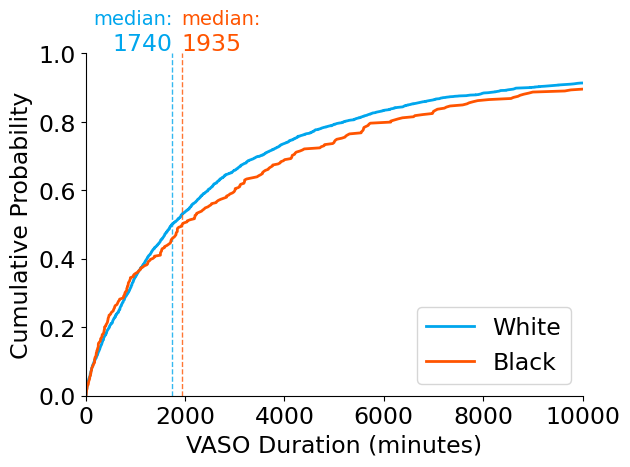

vent
	white: 3351 2430.0
	black: 359 3419.0
	p-value: 0.015476331151773373


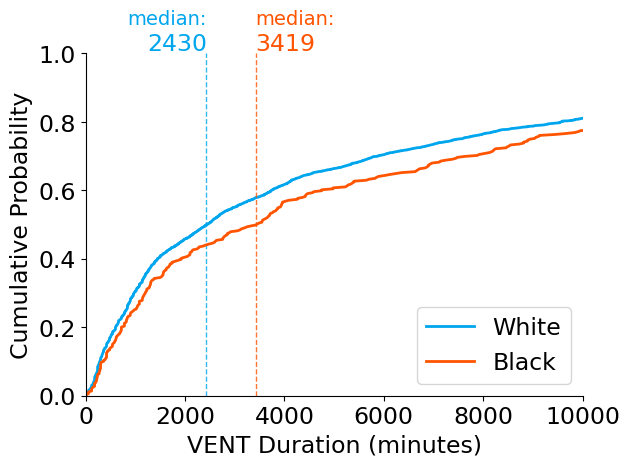

In [12]:
colors = ['#00A6ED', '#FF5400']
for treatment in T.keys():
    i = 0
    
    fig = plt.figure(treatment)

    white_median = np.median(list(T[treatment]['White'].values()))
    black_median = np.median(list(T[treatment]['Black'].values()))
    larger_median = min(white_median, black_median)
        
    for demographic in ['White', 'Black']:
        vals = list(T[treatment][demographic].values())
        plt.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
        plt.xlim((0,10000))
        plt.ylim((0,1.0))

        median = np.median(vals)
        plt.axvline(x=median, linestyle='--', lw=1, color=colors[i], alpha=0.8) 
        if median == larger_median:
            p = 10
            h = 'right'
        else:
            p = -10
            h = 'left'
        plt.text(x=median+p, y=1.085, horizontalalignment=h, s='median:', fontsize=14, color=colors[i])
        plt.text(x=median+p, y=1.01 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[i])

        i += 1

    ax = plt.subplot(111)    
    ax.spines['top'].set_visible(False)    
    ax.spines['right'].set_visible(False)    
    plt.yticks(fontsize=17)    
    plt.xticks(fontsize=17) 

    plt.legend(loc=4, fontsize=17)
    plt.ylabel('Cumulative Probability', fontsize=17)
    plt.xlabel(f'{treatment.upper()} Duration (minutes)', fontsize=17)

    plt.tight_layout()
    plt.savefig(f'{OUTPUT}/race_mimic_{treatment}.png')

    p1 = list(T[treatment]['White'].values())
    p2 = list(T[treatment]['Black'].values())
    w = mannwhitneyu(p1, p2)
    print(treatment)
    print('\twhite:', len(p1), white_median)
    print('\tblack:', len(p2), black_median)
    print('\tp-value:', w.pvalue)
    
    plt.show()

In [13]:
oasis_df = pd.read_parquet(f'{DATA_LOCATION}/oasis_df.parquet')
oasis_df.columns = [col.upper() for col in oasis_df.columns]
severities = dict(oasis_df[['HADM_ID','OASIS']].values)
print(len(severities))

41540


In [14]:
treatment_severity_populations = {treatment:[] for treatment in T.keys()}
for treatment,race_cohorts in T.items():
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            severity = severities[hadm_id]
            treatment_severity_populations[treatment].append(severity)

treatment_severity_thresholds = {}
for treatment, scores in treatment_severity_populations.items():
    vals = sorted(scores)
    n = len(vals)
    print(treatment, vals[int(n/3)], vals[int(2*n/3)], '||', len(vals[:int(n/3)]), len(vals[int(n/3):int(2*n/3)]), len(vals[int(2*n/3):]))
    treatment_severity_thresholds[treatment] = vals[int(n/3)], vals[int(2*n/3)]

vaso 35 42 || 1122 1122 1123
vent 36 43 || 1236 1237 1237


In [15]:
T_risk = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))
for treatment,race_cohorts in T.items():
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            # acuity bin
            severity = severities[hadm_id]
            if severities[hadm_id] <= treatment_severity_thresholds[treatment][0]:
                acuity = 'low'
            elif severities[hadm_id] <= treatment_severity_thresholds[treatment][1]:
                acuity = 'medium'
            else:
                acuity = 'high'

            T_risk[treatment][acuity][race].append(amount)

for treatment,cohorts in T_risk.items():
    print(treatment)
    for severity in ['low', 'medium', 'high']:
        print('\t', severity)
        cohort = cohorts[severity]
        for race,ids in cohort.items():
            print('\t\t', race, len(ids))

vaso
	 low
		 Black 113
		 White 1170
	 medium
		 Black 91
		 White 920
	 high
		 Black 115
		 White 958
vent
	 low
		 Black 132
		 White 1262
	 medium
		 Black 107
		 White 1092
	 high
		 Black 120
		 White 997


vaso
	 vaso low
		white: 1170 1314.5
		black: 113 1260.0
		p-value: 0.9200524442069671


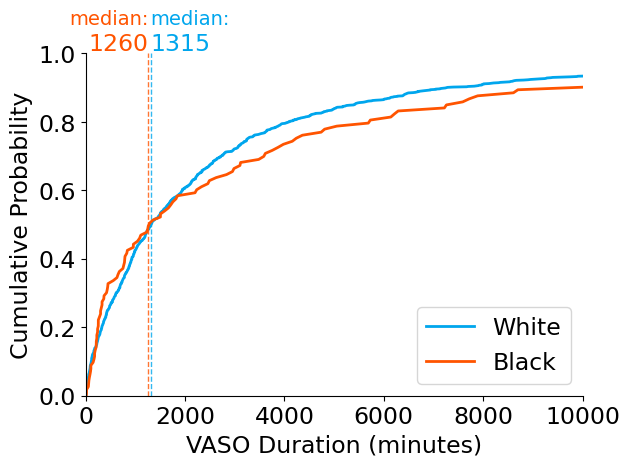

	 vaso medium
		white: 920 1765.0
		black: 91 2046.0
		p-value: 0.48427863074701416


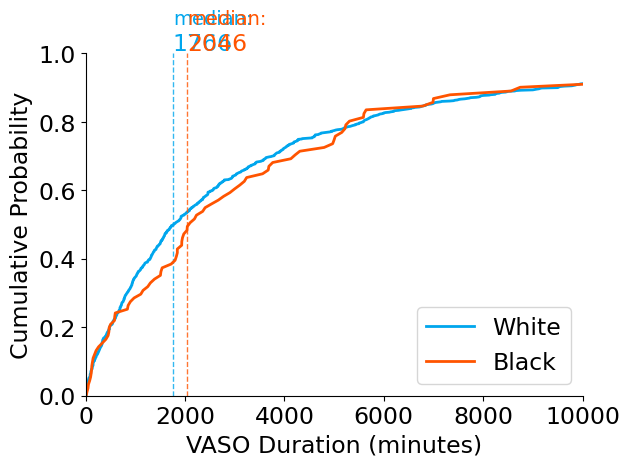

	 vaso high
		white: 958 2296.5
		black: 115 2715.0
		p-value: 0.7361677841259997


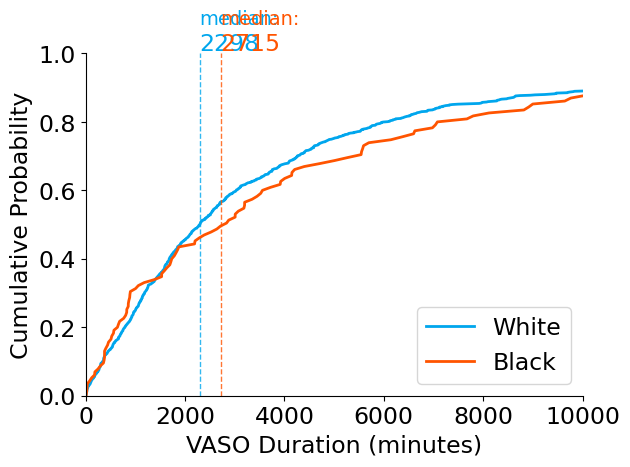

vent
	 vent low
		white: 1262 1455.5
		black: 132 2884.0
		p-value: 0.005941401034971477


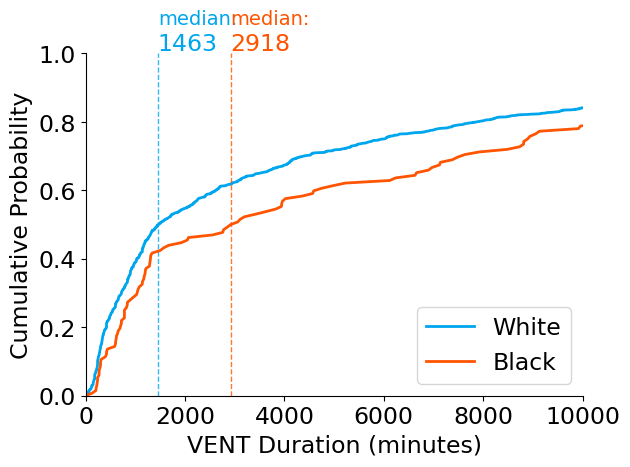

	 vent medium
		white: 1092 2658.5
		black: 107 3559.0
		p-value: 0.4828796157073776


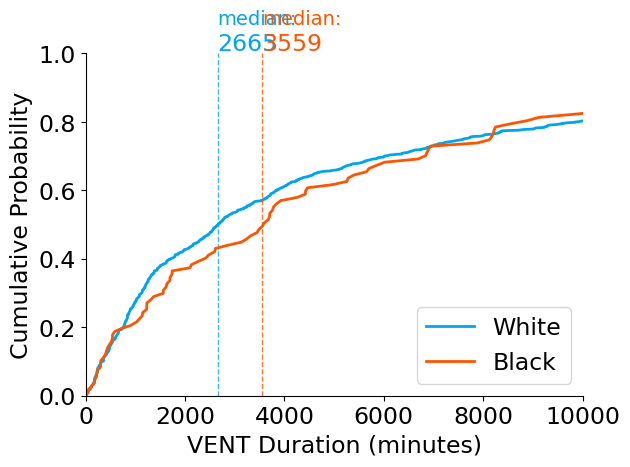

	 vent high
		white: 997 3415.0
		black: 120 3605.5
		p-value: 0.6200961527931166


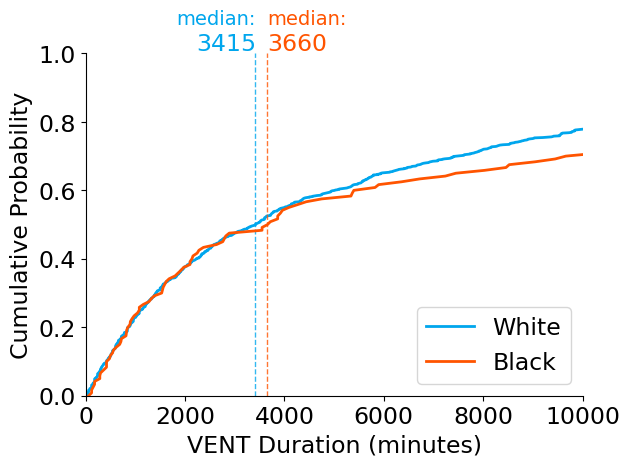

In [16]:
for treatment in T_risk.keys():
    print(treatment)

    for severity in ['low','medium','high']:
        fig = plt.figure('-'.join([treatment,severity]))
        print('\t', treatment, severity)

        white_median = np.median(list(T_risk[treatment][severity]['White']))
        black_median = np.median(list(T_risk[treatment][severity]['Black']))
        larger_median = min(white_median, black_median)
        
        for i,demographic in enumerate(['White', 'Black']):
            vals = list(T_risk[treatment][severity][demographic])
            #print(len(vals))
            #print (np.sort(vals)[int(len(vals)/2)])
            plt.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
            plt.xlim((0,10000))
            plt.ylim((0,1.0))

            median = np.sort(vals)[int(len(vals)/2)]
            plt.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
            if median == larger_median:
                p = 10
                h = 'right'
            else:
                p = -10
                h = 'left'
            #h = 'center'
            plt.text(x=median+p, y=1.085, horizontalalignment=h, s='median:', fontsize=14, color=colors[i])
            plt.text(x=median+p, y=1.01 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[i])

        ax = plt.subplot(111)    
        ax.spines['top'].set_visible(False)    
        #ax.spines["bottom"].set_visible(False)    
        ax.spines['right'].set_visible(False)    
        #ax.spines["left"].set_visible(False)    
        plt.yticks(fontsize=17)    
        plt.xticks(fontsize=17) 

        plt.legend(loc=4, fontsize=17)
        plt.ylabel('Cumulative Probability', fontsize=17)
        plt.xlabel(f'{treatment.upper()} Duration (minutes)', fontsize=17)

        plt.tight_layout()
        plt.savefig(f'{OUTPUT}/race_mimic_{treatment}_{severity}.png')

        p1 = list(T_risk[treatment][severity]['White'])
        p2 = list(T_risk[treatment][severity]['Black'])
        w = mannwhitneyu(p1, p2)
        print('\t\twhite:', len(p1), white_median)
        print('\t\tblack:', len(p2), black_median)
        print('\t\tp-value:', w.pvalue)
        plt.show()
    #exit()